#                                      PNEUMONIA DETECTION

In [1]:
#imports
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

import random
import glob
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


In [2]:
from tensorflow.keras.losses import categorical_crossentropy

In [3]:
#Loading dataset
train_path = "C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/train/"
test_path  = "C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test/"

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
test_pneumonia

['C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1135262-0001.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1135262-0002.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1135262-0003.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1135262-0004.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1220485-0001.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1351146-0001.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1351146-0002.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/test//PNEUMONIA\\BACTERIA-1351146-0003.jpeg',
 'C:/Users/91812/Desktop/books/Project/Pneumonia_Detection/chest_xray/te

In [4]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]
df_train

,class,image
0,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
1,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
2,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
3,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
4,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
...,...,...
5227,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
5228,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
5229,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
5230,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...


In [5]:
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]
df_test

,class,image
0,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
1,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
2,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
3,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
4,Normal,C:/Users/91812/Desktop/books/Project/Pneumonia...
...,...,...
619,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
620,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
621,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...
622,Pneumonia,C:/Users/91812/Desktop/books/Project/Pneumonia...


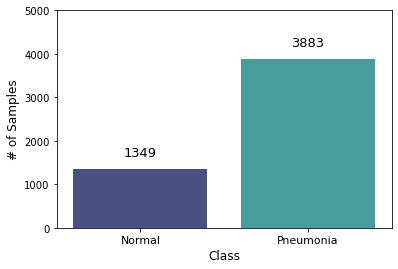

In [6]:
#exploring data distribution
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

Train Set - Normal


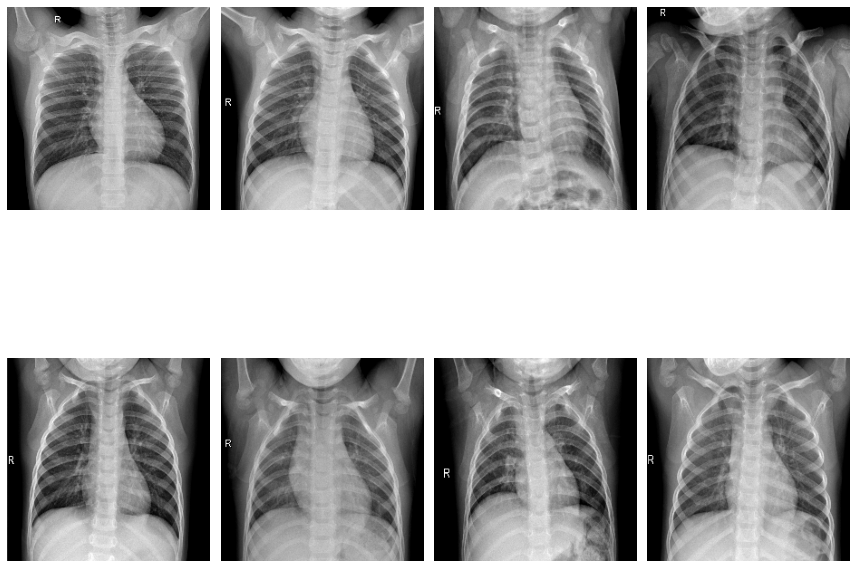

In [7]:
IMG_SIZE = 224

print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 8):
    plt.subplot(2,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pheumonia


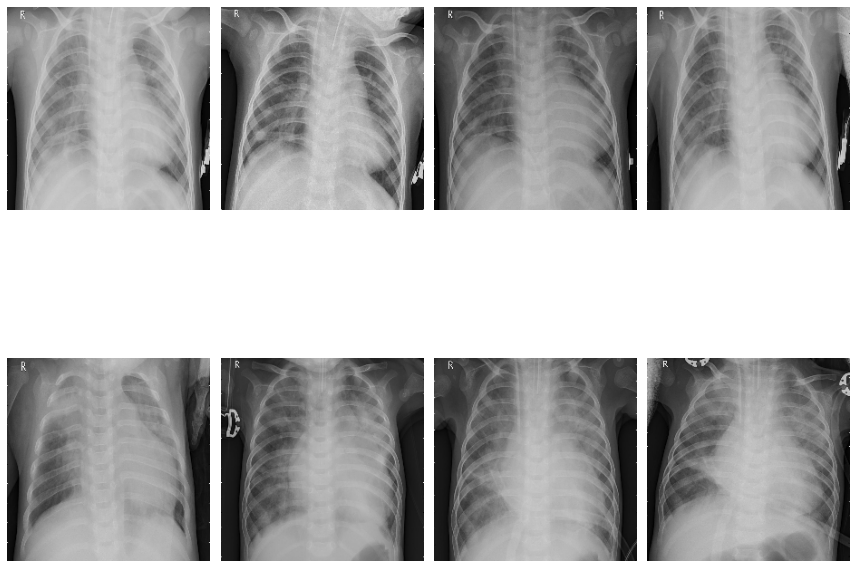

In [8]:
print('Test Set - Pheumonia')

plt.figure(figsize=(12,12))

for i in range(0, 8):
    plt.subplot(2,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [9]:
#splitting dataset into train & validation
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state =42 , stratify = df_train['class'])

In [10]:
#Data Augmentaion
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

Batch = 32
#generation augmented data
ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'categorical',
                                             batch_size = Batch,
                                             seed = 32)

ds_val  = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'categorical',
                                            batch_size = Batch,
                                            seed = 32)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'categorical',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [11]:
#mobileNet as base Model

base_model = tf.keras.applications.ResNet152V2( weights='imagenet',
                                                input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                include_top=False)


base_model.trainable = False

#Input shape = [width, height, color channels]
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model(inputs)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

output = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=[inputs], outputs=output)  

In [12]:

model.compile(loss='categorical_crossentropy', 
              optimizer = keras.optimizers.Adam(learning_rate=5e-5), 
              metrics='accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 58,594,178
Trainable params: 262,530
Non-trainable params: 58,331,648
___________________________________________

In [13]:
#checkpointing
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [14]:
history = model.fit(ds_train,
          batch_size = 32, 
          epochs = 5,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/32),
          validation_steps=(len(val_df)/32));

Epoch 1/5
130/130 [==============================] - 1940s 14s/step - loss: 0.3949 - accuracy: 0.8232 - val_loss: 0.2455 - val_accuracy: 0.9102
Epoch 2/5
130/130 [==============================] - 1916s 15s/step - loss: 0.2125 - accuracy: 0.9176 - val_loss: 0.1840 - val_accuracy: 0.9312
Epoch 3/5
130/130 [==============================] - 2383s 18s/step - loss: 0.1735 - accuracy: 0.9333 - val_loss: 0.1742 - val_accuracy: 0.9351
Epoch 4/5
130/130 [==============================] - 1581s 12s/step - loss: 0.1545 - accuracy: 0.9398 - val_loss: 0.1382 - val_accuracy: 0.9465
Epoch 5/5
130/130 [==============================] - 676s 5s/step - loss: 0.1417 - accuracy: 0.9441 - val_loss: 0.1360 - val_accuracy: 0.9456


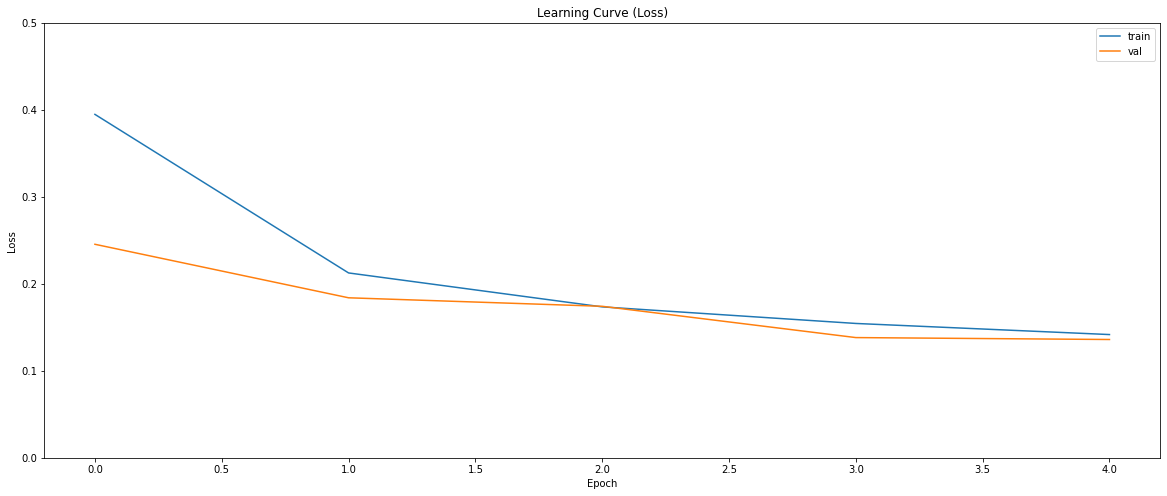

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

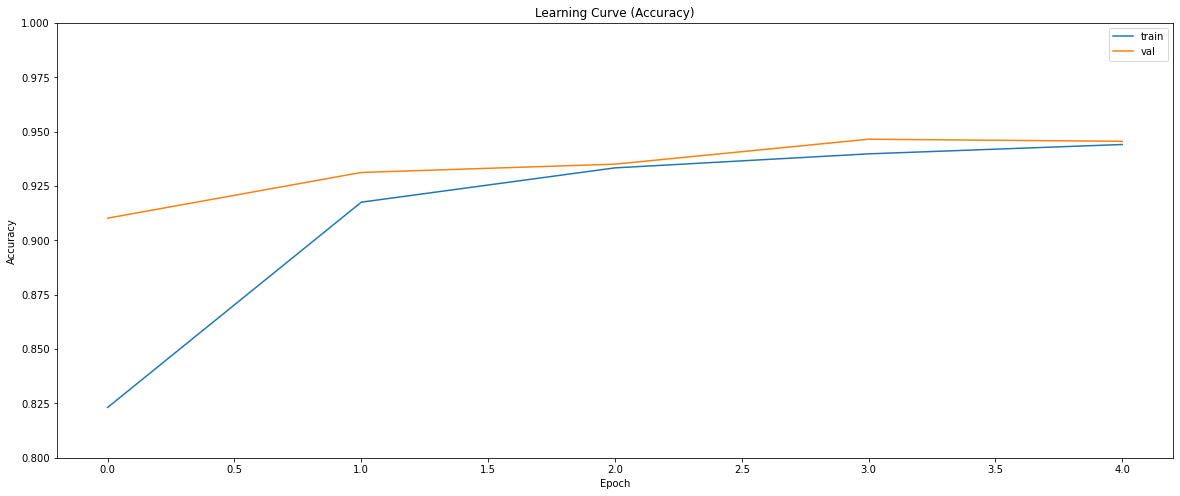

In [17]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [18]:
ds_test.reset()
score = model.evaluate(ds_val, steps = len(val_df)/32, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

score = model.evaluate(ds_test, steps = len(df_test)/32, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.13601082563400269
Val accuracy: 0.9455587267875671
Val loss: 0.7291675806045532
Val accuracy: 0.75


In [25]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
# pred_labels=  np.argmax(predictions[i][0])
# print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))
print(predictions)

[[0.7144743  0.2855257 ]
 [0.89491886 0.10508107]
 [0.93065923 0.06934075]
 ...
 [0.10595687 0.8940431 ]
 [0.02157101 0.978429  ]
 [0.0010948  0.9989052 ]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

In [ ]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [26]:
import h5py
model.save('C:\\Users\\91812\\Desktop\\books\\Project\\Pneumonia_Detection\\model2.h5')